### Deskripsi Dataset

Dataset yang digunakan adalah artikel berita dari BBC yang telah dibuat dalam bentuk yang mudah diakses. Dataset ini terdiri dari 2225 dokumen dari situs berita BBC pada tahun 2004-2005 yang berasal dari lima topik: (business, entertainment, politics, sport, tech).

Dataset aslinya dapat kita akses di [sini](http://mlg.ucd.ie/datasets/bbc.html).

### Mengimpor Modul dan Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

RANDOM_STATE = 1337
np.random.seed(RANDOM_STATE)

In [2]:
plt.rcParams['figure.figsize'] = (12.0, 7.0)

In [3]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

In [5]:
df = pd.read_csv('bbc.csv')

In [6]:
X = df['text']
y = df['y'].astype('category')

### Eksplorasi Awal Data

25 kata-kata yang paling sering muncul dalam semua dokumen.

Kita bisa Gunakan modul `CountVectorizer`.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X_vec = vec.fit_transform(X)
pd.Series(
    np.array(X_vec.sum(axis=0)).flatten(),
    index=vec.get_feature_names()
).nlargest(25)

the     52636
to      25113
of      20008
and     18611
in      17725
for      8945
is       8555
that     8257
it       7893
on       7625
said     7255
was      6028
he       5939
be       5805
with     5354
as       4981
has      4957
have     4772
at       4638
by       4515
will     4473
but      4421
are      4401
from     3535
not      3484
dtype: int64

Nah, ternyata ada banyak kata-kata yang berupa kata hubung dari 25 kata-kata yang paling sering muncul tersebut. Kata-kata ini sering dikenal dengan nama *stopwords*. Hapus kata-kata ini dengan mengatur parameter `stop_words='english'` pada modul `CountVectorizer`. Nanti top 25 words-nya akan berubah!

In [8]:
vec = CountVectorizer(stop_words='english')
X_vec = vec.fit_transform(X)
pd.Series(
    np.array(X_vec.sum(axis=0)).flatten(),
    index=vec.get_feature_names()
).nlargest(25)

said          7255
mr            3005
year          2309
people        2045
new           1978
time          1322
world         1201
government    1160
uk            1115
years         1003
best           974
just           957
make           945
told           911
film           890
like           879
game           871
music          839
000            804
labour         804
bbc            767
set            762
number         760
way            740
added          733
dtype: int64

Kita juga bisa munculkan 25 kata-kata yang sering muncul dari dokumen dalam tiap topik/kategori.

In [9]:
for label in np.unique(y):
    vec = CountVectorizer(stop_words='english')
    X_vec = vec.fit_transform(X[y == label])
    print('=== {} ==='.format(label))
    print(
        pd.Series(
            np.array(X_vec.sum(axis=0)).flatten(),
            index=vec.get_feature_names()
        ).nlargest(25)
    )

=== business ===
said          1680
year           713
mr             600
market         434
new            417
company        416
growth         385
firm           362
economy        359
government     341
bank           335
sales          317
2004           310
economic       310
oil            296
shares         265
world          252
000            247
years          247
prices         246
chief          240
china          225
business       223
uk             215
expected       213
dtype: int64
=== entertainment ===
said        825
film        788
best        619
year        455
music       435
new         323
awards      273
award       244
uk          234
won         233
years       228
number      227
star        222
band        215
director    214
tv          214
people      205
actor       203
mr          195
british     194
time        190
album       188
films       188
bbc         183
song        166
dtype: int64
=== politics ===
said          2241
mr            1686
labou

### Clustering dengan k-Means

Kita akan melakukan vektorisasi terhadap dokumen menggunakan modul [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Penjelasan tentang metode **TF-IDF** bisa dilihat di [sini](http://tfidf.com/), ya. Intinya sebuah dokumen bisa  direpresentasikan ke dalam bentuk vektor seperti bag-of-words, tetapi kata yang sering muncul di berbagai dokumen, seperti halnya *stopwords*, bakal dibobotkan lebih kecil.

Nah, vektor yang dihasilkan dengan TF-IDF akan memiliki dimensi yang cukup besar. Biar mudah divisualisasikan, kita perlu mereduksi dimensinya. Kali ini kita akan menggunakan modul `TruncatedSVD` untuk menghasilkan **dua komponen prinsipil**. Modul ini bekerja seperti halnya *Principal Component Analysis* (PCA).

Di bawah ini merupakan *scatter plot* dari dua dimensi yang dihasilkan. *Stopwords* akan dihapus dari dokumen saat melakukan vektorisasi. Lalu, tiap titik ini akan berwarna sesuai topiknya.

In [10]:
colors = np.array(sns.color_palette())
y_int = y.astype('category').cat.codes

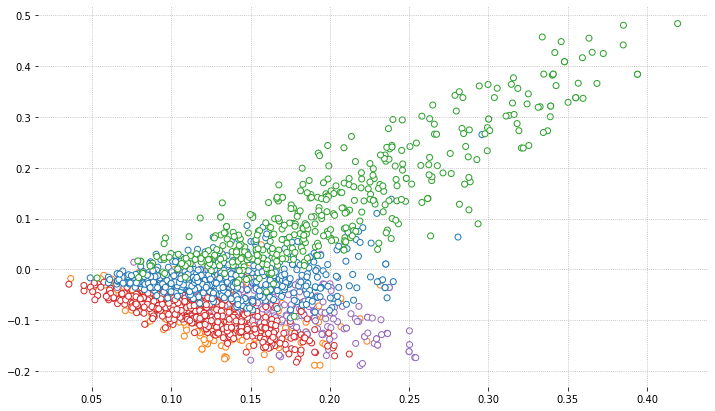

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    TruncatedSVD(2, random_state=42)
)
X_vec = pipe.fit_transform(X)
plt.scatter(
    *X_vec.T,
    edgecolors=colors[y_int],
    facecolors='w'
)
plt.grid(linestyle=':')
sns.despine(left=True, bottom=True)

Jadi, deh!

Tapi tapi tapi, ada cara untuk melakukan visualisasi dari dokumen lain dan lebih baik, loh! Kita bakal menggunakan metode reduksi dimensi yang lebih canggih, misalnya dengan [t-SNE](https://lvdmaaten.github.io/tsne/). Jadi, pertama kita akan mereduksi jadi 100 dimensi menggunakan modul`TruncatedSVD`. Kemudian dari vektor 100-dimensi tersebut, reduksi kembali dimensinya dengan menggunakan modul `TSNE` dari scikit-learn. Atur parameter `random_state=42` pada TSNE agar hasilnya dapat direproduksi.


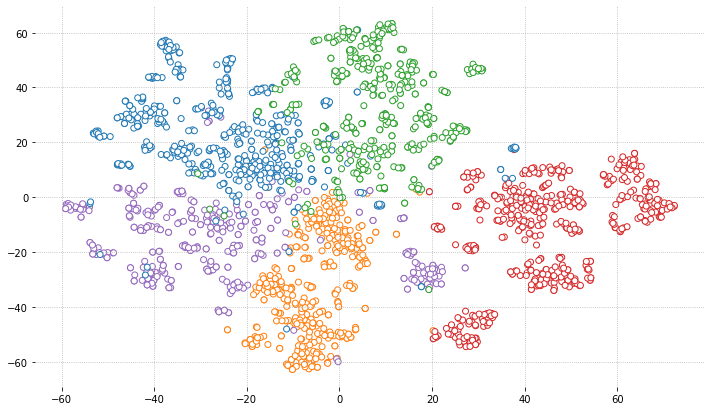

In [12]:
from sklearn.manifold import TSNE

pipe = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    TruncatedSVD(100, random_state=42),
    TSNE(2, random_state=42)
)
X_vec = pipe.fit_transform(X)
plt.scatter(
    *X_vec.T,
    edgecolors=colors[y_int],
    facecolors='w'
)
plt.grid(linestyle=':')
sns.despine(left=True, bottom=True)

Selanjutnya kita coba melakukan clustering dengan `KMeans`. Jumlah komponennya disamakan dengan jumlah kelasnya saja, ya, yaitu 5.

In [13]:
vec = TfidfVectorizer(stop_words='english')
doc = vec.fit_transform(X)

pipeline = make_pipeline(TruncatedSVD(n_components=100, random_state=42), TSNE(random_state=42))

X = df['text']

tsne_result = pipeline.fit_transform(doc)

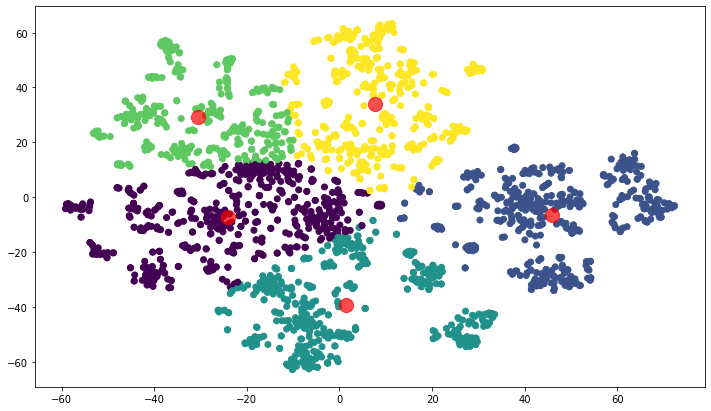

In [14]:
from sklearn.cluster import KMeans

kmeans_5 = KMeans(n_clusters=5, random_state=13).fit(tsne_result)
y_kmeans = kmeans_5.predict(tsne_result)
centers = kmeans_5.cluster_centers_

plt.scatter(tsne_result[:,0], tsne_result[:,1], c=y_kmeans )
plt.scatter(centers[:,0], centers[:, 1], c='red', s = 200, alpha=0.7)